# Expected Earnings by College Major
#### A DataQuest guided project.

What follows is investigation of data collected regarding job outcomes of students from a variety of majors who graduated from college between 2010 and 2012.  The data orginally comes from a US census [survey](https://www.census.gov/programs-surveys/acs/), but it was further cleaned by [FiveThirtyEight](https://github.com/fivethirtyeight/data/tree/master/college-majors).

### 1 The Data

The columns in the dataset are shown below.

* `Rank` - Rank by median earnings (the dataset is ordered by this column).
* `Major_code` - Major code.
* `Major` - Major description.
* `Major_category` - Category of major.
* `Total` - Total number of people with major.
* `Sample_size` - Sample size (unweighted) of full-time.
* `Men` - Male graduates.
* `Women` - Female graduates.
* `ShareWomen` - Women as share of total.
* `Employed` - Number employed.
* `Median` - Median salary of full-time, year-round workers.
* `Low_wage_jobs` - Number in low-wage service jobs.
* `Full_time` - Number employed 35 hours or more.
* `Part_time` - Number employed less than 35 hours.

Questions that we could ask:

* Does the popularity of a major correlate with earning potential?
* What is the gender distribution among graduates in the various majors?
* What category of majors is most popular?

Other potentially interesting questions (not specifically mentioned in the instructions):

* How do majors compare in terms of fully employed graduates?  Total employed?
* Are graduates in some majors more likely than others to wind up in low wage service jobs?

Before asking these questions, we have some prelimaries to take care of.

### 2 Preliminaries and Cleaning

In [2]:
import pandas as pd
import pandas.plotting as pd_plotting
import matplotlib.pyplot as plt
from IPython.display import display # for pretty printing pandas dataframes

%matplotlib inline

In [3]:
recent_grads = pd.read_csv('recent-grads.csv')

#### Removing Null Values

In [4]:
raw_data_count = recent_grads.shape[0]
raw_data_count

173

In [5]:
recent_grads = recent_grads.dropna()
cleaned_data_count = recent_grads.shape[0]
cleaned_data_count

172

It appears we only need to remove one row on account of a missing value.    

#### Cleaning Up column_names

Now, let's clean up the column names a bit, converting them all into [snake_case](https://medium.com/@pddivine/string-case-styles-camel-pascal-snake-and-kebab-case-981407998841).  I'll leave the percentile columns the way they are, since underscores wouldn't add anything to their readability.

In [6]:
recent_grads.columns = [col.lower() for col in recent_grads.columns]
recent_grads.rename(columns = {'sharewomen':'share_women'}, inplace = True)
recent_grads.columns

Index(['rank', 'major_code', 'major', 'total', 'men', 'women',
       'major_category', 'share_women', 'sample_size', 'employed', 'full_time',
       'part_time', 'full_time_year_round', 'unemployed', 'unemployment_rate',
       'median', 'p25th', 'p75th', 'college_jobs', 'non_college_jobs',
       'low_wage_jobs'],
      dtype='object')

### 3 Analysis
#### Do popular majors provide better earning potential?

To attempt to answer this question we are instructed to plot the `sample_size` and `median` and `unemployment_rate` categories.  However, this presupposes that `sample_size` correlates to popularity.  How could we verify that this is so?  Well, testing whether the the sample sizes are roughly proportional to the total number of students in each major would ease my mind.  

In [7]:
totals = recent_grads['total'].values
samples = recent_grads['sample_size'].values
prop = totals / samples
prop[:10]

array([ 64.97222222, 108.        , 285.33333333,  78.625     ,
       111.62629758, 151.35294118,  74.05882353, 179.2       ,
        88.65597668, 129.20285261])

Well, there is a significant amount of variation in the proportion of sample size to total number of students in each major:  over ten fold in a few cases (not shown).  I don't see how we can use the sample size to make any judgments about the popularity of a major.  Instead, we should probably be comparing the total number of students.  We will make both comparisons.

Rather than using the built-in pandas plotting functionality, we will resort to straight matplotlib to facillitate comparison between the plots.

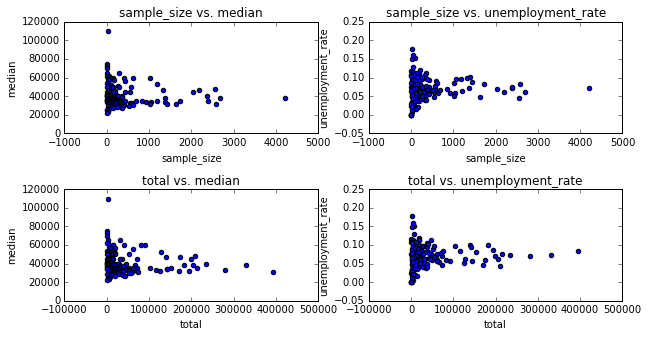

In [8]:
def scatter_series(df, xcols, ycols, shape, figsize=(10,5),
                  titles=[], xlabels=[], ylabels=[]):
    """
    Plots df[xcol] vs. df[ycol] for xcol, ycol in xcols, ycols.
    
    xcols and ycols must have the same length, and shape must be a
    tuple that fits into the plt.subplots() call.  You do the math.
    
    Sorry:  isn't working for all numbers and shapes of plots.
    """
    fig, axes = plt.subplots(*shape, figsize=figsize)
    plot_num = 0
    for i in range(shape[0]):
        for j in range(shape[1]):
            axes[i][j].scatter(df[xcols[plot_num]], df[ycols[plot_num]])
            if titles:
                axes[i][j].set_title(titles[plot_num])
            if xlabels:
                axes[i][j].set_xlabel(xlabels[plot_num])
            if ylabels:
                axes[i][j].set_ylabel(ylabels[plot_num])
            plot_num += 1
    fig.subplots_adjust(hspace=0.5)
    plt.show()
    
    
xcols = ['sample_size', 'sample_size', 'total', 'total']
ycols = ['median', 'unemployment_rate', 'median', 'unemployment_rate']
titles = ['{} vs. {}'.format(x, y) for x,y in zip(xcols, ycols)]
scatter_series(recent_grads, xcols, ycols, (2,2),
               titles=titles, xlabels=xcols, ylabels=ycols)

From these plots it appears that there is not a noticeable relationship between sample size and either median income or unemployment rate.   Regardless of the popularity of the major (putting my qualms about the use of that term aside), the mean of each of those economic indicators is roughly the same.

#### Do students majoring in majors that are predominantly female make more money?

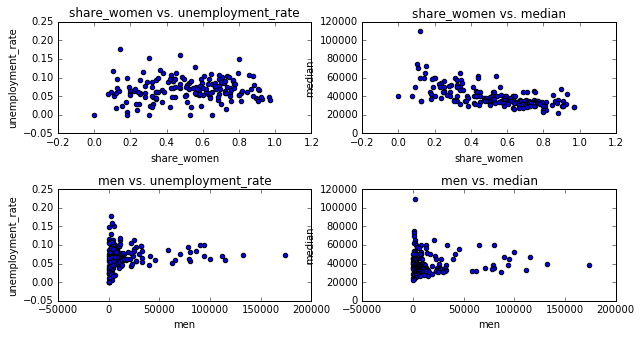

In [9]:
xcols = ['share_women', 'share_women', 'men', 'men']
ycols = ['unemployment_rate', 'median', 'unemployment_rate', 'median']
titles = ['{} vs. {}'.format(x, y) for x,y in zip(xcols, ycols)]
scatter_series(recent_grads, xcols, ycols, (2,2),
               titles=titles, xlabels=xcols, ylabels=ycols)

It is pretty clear that there is no relation between gender and unemployment rate.  But why do the leftmost plots look so different?  This is due to the nature of the data being plotted along the x-axis.  The distribution of the `share_women` category is rather uniform, whereas the total number of students in the various majors grows exponentially in the data set.  A simple transformation can confirm this.

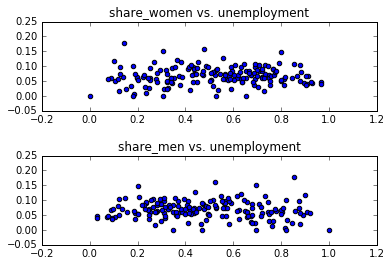

In [10]:
# transformation
recent_grads['share_men'] = recent_grads['men'] / recent_grads['total']

# plotting
fig, (axs) = plt.subplots(2)
axs[0].scatter(recent_grads['share_women'], recent_grads['unemployment_rate'])
axs[1].scatter(recent_grads['share_men'], recent_grads['unemployment_rate'])
axs[0].set_title('share_women vs. unemployment')
axs[1].set_title('share_men vs. unemployment')
fig.subplots_adjust(hspace=0.5)
plt.show()

Regarding the other plots, there seems to be a slight negative correlation between the share of women in a major and its median income potential.   This is, unfortunately, not surprising, given the well known [gender disparity](https://www.pewresearch.org/fact-tank/2019/03/22/gender-pay-gap-facts/) in wages in this country.  Out of curiousity, let us use our new `share_men` column to make an apples to apples comparison with `share_women` with respect to `median` income.

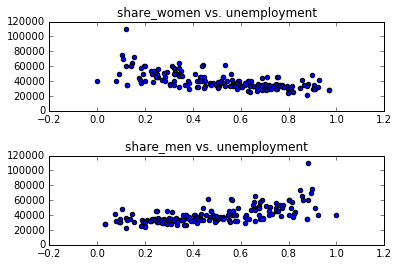

In [11]:
fig, (axs) = plt.subplots(2)
axs[0].scatter(recent_grads['share_women'], recent_grads['median'])
axs[1].scatter(recent_grads['share_men'], recent_grads['median'])
axs[0].set_title('share_women vs. unemployment')
axs[1].set_title('share_men vs. unemployment')
fig.subplots_adjust(hspace=0.5)
plt.show()

Like mirror images of one another.

#### Is there a link between full-time workers and median salary?

I should think yes?


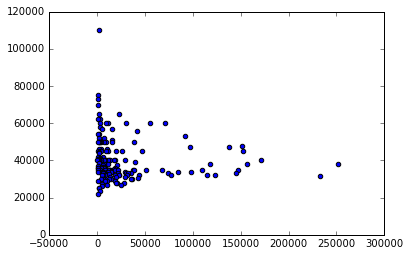

In [12]:
fig, ax = plt.subplots()
ax.scatter(recent_grads['full_time'], recent_grads['median'])
plt.show()

Not much of a trend is apparent.  Let us try the same sort of transformation, normalizing full timers as a percentage of total graduates.

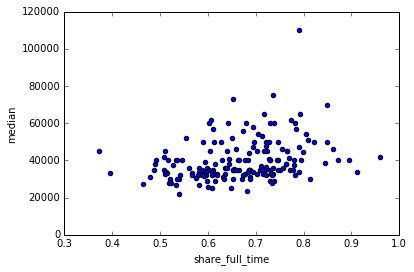

In [13]:
recent_grads['share_full_time'] = recent_grads['full_time'] / recent_grads['total']
recent_grads.plot(x='share_full_time', y='median', kind='scatter')
plt.show()

There might be a slight positive correlation, but it is not very pronounced. 

#### Histograms

Next, let's generate a bunch of histograms, using `Series.hist()`.

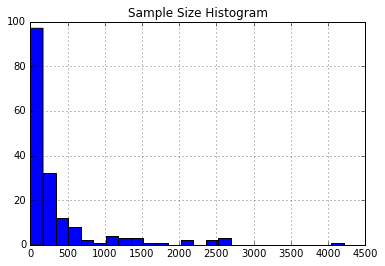

In [14]:
ax = recent_grads['sample_size'].hist(bins=25)
ax.set_title('Sample Size Histogram')
plt.show()

Sample size is exponentially decreasing, with almost all of the sample in the 0-500 range.

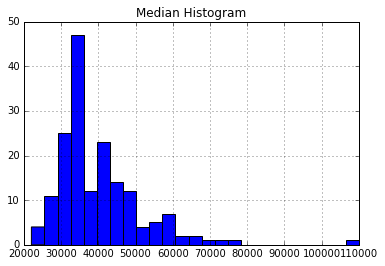

In [15]:
ax = recent_grads['median'].hist(bins=25)
ax.set_title('Median Histogram')
plt.show()

Median income is right skewed, meaning that the bulk of the distribution are on the lower end of the scale, with a median of about $35,000.  There is an odd dip in the bins right below $40,000.



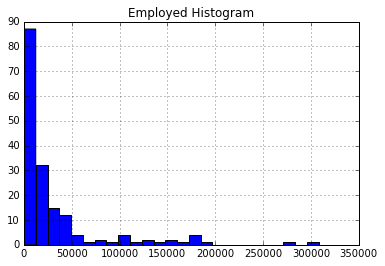

In [16]:
ax = recent_grads['employed'].hist(bins=25)
ax.set_title('Employed Histogram')
plt.show()

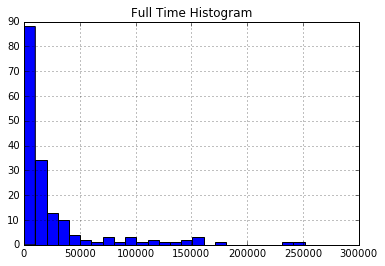

In [17]:
ax = recent_grads['full_time'].hist(bins=25)
ax.set_title('Full Time Histogram')
plt.show()

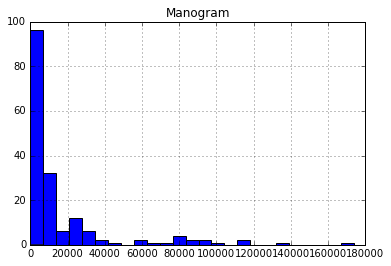

In [18]:
ax = recent_grads['men'].hist(bins=25)
ax.set_title('Manogram')
plt.show()

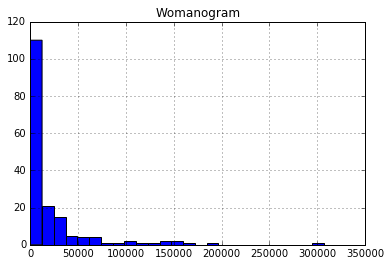

In [19]:
ax = recent_grads['women'].hist(bins=25)
ax.set_title('Womanogram')
plt.show()

The categories that are just counts (number of full timers, number of employed) follow the distribution of the sample sizes quite closely, since they haven't been normalized.

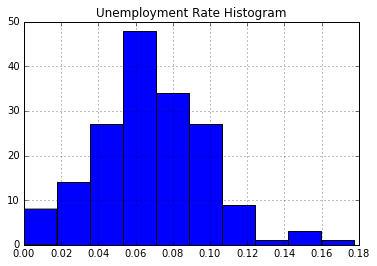

In [20]:
ax = recent_grads['unemployment_rate'].hist(bins=10)
ax.set_title('Unemployment Rate Histogram')
plt.show()

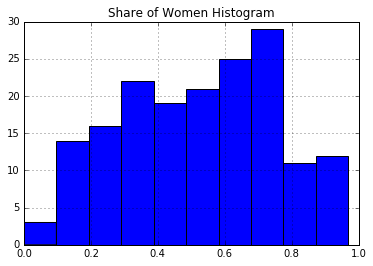

In [21]:
ax = recent_grads['share_women'].hist(bins=10)
ax.set_title('Share of Women Histogram')
plt.show()

#### Which percent of majors are predominantly male?  Female?

The answer to this question depends on what is meant by 'predominantly'.  Is a major 'predominantly female' if it has more than 50% women in it?  Or should we require a higher threshold of membership?  I will opt to require a higher threshold.

In [22]:
percent = 85
women = recent_grads['share_women']
mostly_female = women[women > percent / 100]
mostly_male = women[women < 1- (percent / 100)]
print("{}% female: ".format(percent), len(mostly_female))
print("{}% male: ".format(percent), len(mostly_male))


85% female:  14
85% male:  11


#### Scatter Matrices

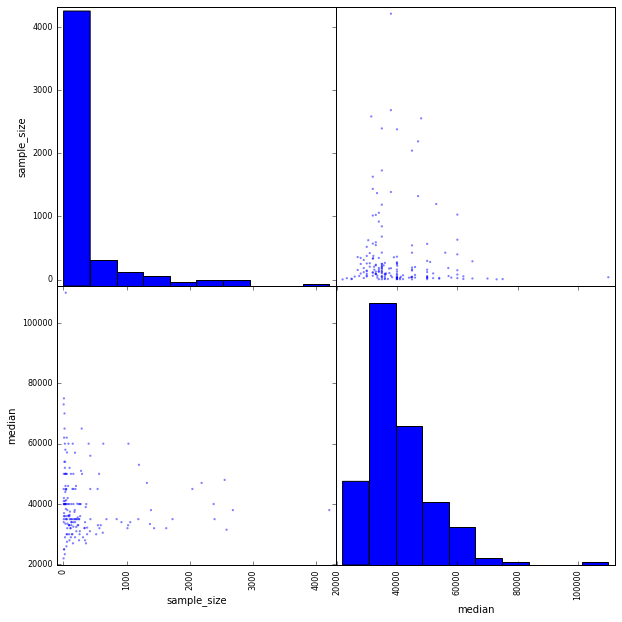

In [23]:
pd_plotting.scatter_matrix(recent_grads[['sample_size', 'median']], figsize=(10,10))
plt.show()

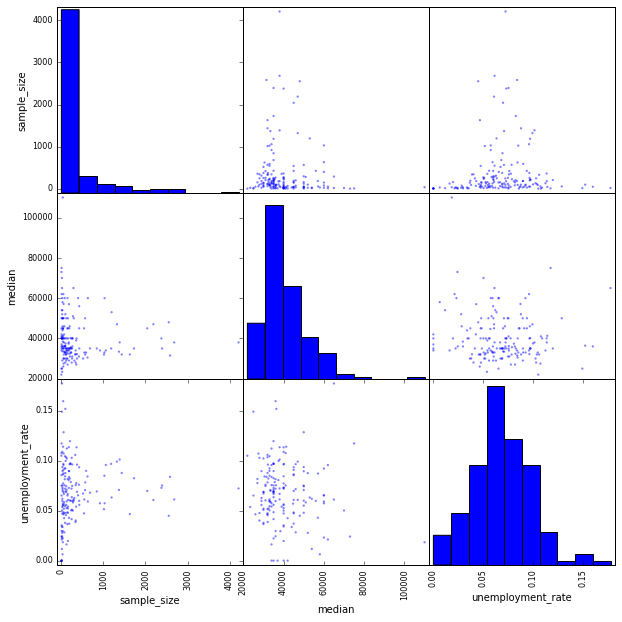

In [24]:
pd_plotting.scatter_matrix(recent_grads[['sample_size',
                                         'median', 'unemployment_rate']], figsize=(10,10))
plt.show()

#### Bar Plots



This is the example from the project:

[]

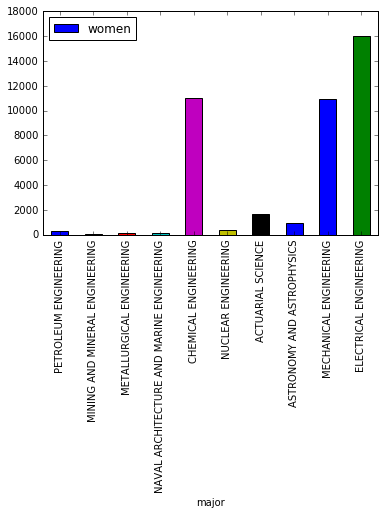

In [25]:
recent_grads[:10].plot.bar(x='major', y='women')
plt.plot()

My question is:  why does setting `y='women'` put women in a legend, and not as a why label.   And if all bars represent shares of women, why are they not all the same color?  It is the same when you run it through `pd.plot`.

[]

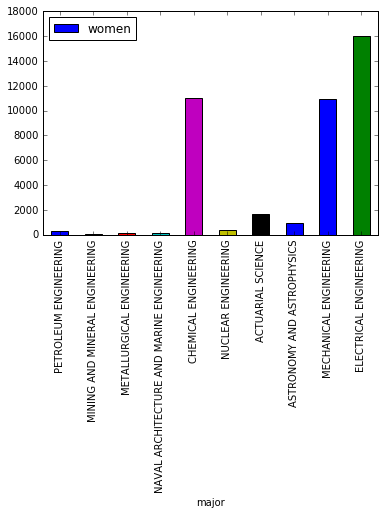

In [26]:
recent_grads[:10].plot(x='major', y='women', kind='bar')
plt.plot()

From the [docs](https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.DataFrame.plot.bar.html) it appears that this is standard behavior for the `pd.plot` wrapper.  Although [this](https://stackoverflow.com/questions/49984388/getting-single-color-for-pandas-barplot-instead-of-colormap) indicates that the opposite problem can occur.  Let's fix this.  But what color should we use...

### All the Colors of the Matplotlib Rainbow

![All the (Named) Colors of the Matplotlib Rainbow](https://i.stack.imgur.com/lFZum.png)

I didn't know 'peru' was a color!

[]

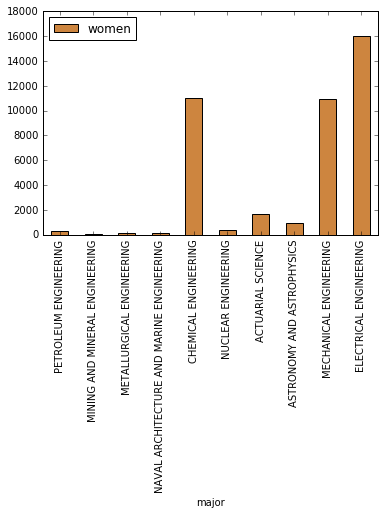

In [27]:
recent_grads[:10].plot(x='major', y='women', kind='bar', color='peru')
plt.plot()

#### And then some more plotting



I will now plot a few more different types of plots that are supported by the pandas plotting functionality.  

First, let us plot the share of men and of women among all of the different _categories_ of majors.  To do this, we start by grouping our recent grads according to the `major_category` category.

In [60]:
r = recent_grads.groupby('major_category')[['share_men', 'share_women']]
r

This produces a `DataFrameGroupBy` object, not a `DataFrame`, but we can transform it into the latter by the following indexing operation:

In [61]:
r = r.mean()
r

,share_men,share_women
major_category,,
Agriculture & Natural Resources,0.594733,0.405267
Arts,0.396342,0.603658
Biology & Life Science,0.412807,0.587193
Business,0.516802,0.483198
Communications & Journalism,0.341616,0.658384
Computers & Mathematics,0.688228,0.311772
Education,0.251493,0.748507
Engineering,0.761111,0.238889
Health,0.204848,0.795152


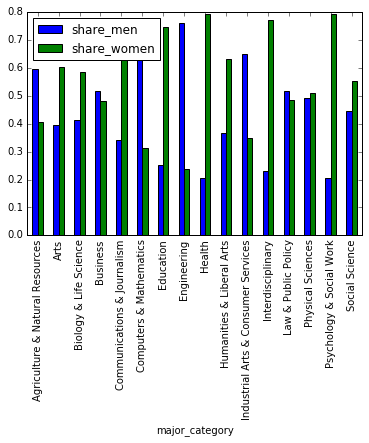

In [62]:
r.plot.bar()
plt.show()

It looks like women are somewhat predominant (say, 60% or more) in the Arts, Life Sciences (almost, at least)
and very predominant in Heal, Psychology/Social Work, Communication/Journalism and 'Interdisciplinary'.  Men
are somewhat predominant in Agriculture and Industrial/Consumer Arts and very predominant in Computer/Math and 
Engineering.  The rest are split more evenly between the genders.

### Box Plots

#### Median Salaries

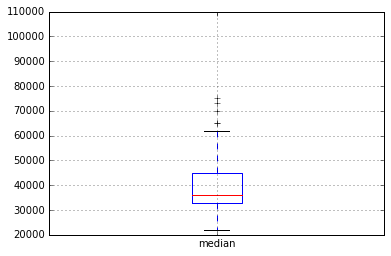

In [67]:
ax = recent_grads['median'].plot.box(grid=True)

Looks like the mean median is around $35,000, while the quarter percentiles are at around

* $25 \text{ percentile}\approx \$32,000$
* $75 \text{ percentile}\approx \$45,000$

There are four outliers above the upper whisker, between \$62,000 and \$76,000.



#### Unemployment Rate

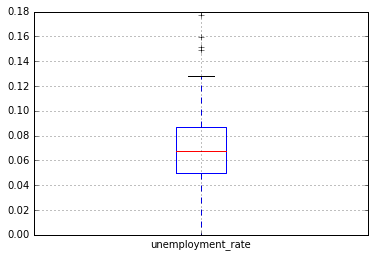

In [68]:
ax = recent_grads['unemployment_rate'].plot.box(grid=True)

Here are the quartiles:

* $25 \text{ percentile}\approx 0.05$
* $50 \text{ percentile}\approx 0.07$
* $75 \text{ percentile}\approx 0.085$

The upper whisker ends at around 0.13, but there are four outliers between there and the maximum of 0.18.

### Hexagonal Bin Plots


I wasn't familiar with these plots.  From the [docs](http://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html):

>You can create hexagonal bin plots with DataFrame.plot.hexbin(). Hexbin plots can be a useful alternative to scatter plots if your data are too dense to plot each point individually.

Looking back at our scatter plots, `sample_size` versus `median` seems rather dense... at least in the lower left corner.  Let's try that one.

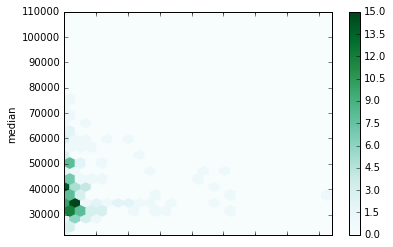

In [77]:
recent_grads.plot.hexbin(x='sample_size', y='median', gridsize=25)
plt.show()

Well, that's a bit too spread out still, I guess.  But it's neat.  But none of the scatter plots are especially dense.  Here is another sample.

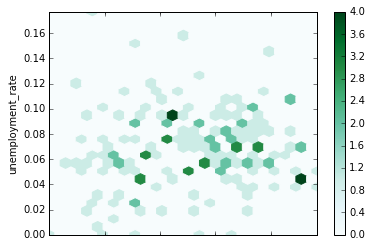

In [78]:
recent_grads.plot.hexbin(x='share_women', y='unemployment_rate', gridsize=25)